# Imports

In [1]:
import os
import json

import numpy as np
from matplotlib import pyplot as plt
import soundfile as sf
import librosa

import torch
from torch.utils.data import Dataset

# Read Data Set and Preprocessing

## Read Data Set

- Store all the training data in DATA_PATH
- Use the same name for audio file and label file, for example:
  - Audio file name: "audio-1.wav"
  - Label file name: "audio-1.json"
- For more details about audio and label format, see [Audio-Spectrum-Labeling-Toolset](https://github.com/Fangjun-Zhou/Audio-Spectrum-Labeling-Toolset)

## Preprocessing

- TIME_SCALE is the scale of time span for each window. For example, if TIME_SCALE is 1, then each window will be a square. The length of each window will be equal to the height of audioSpectrogram.
  - For species making longer sounds, increase TIME_SCALE to make sure their audio fits in the window.

In [33]:
# The path for all data sets.
DATA_PATH = "data"
# Spectrogram frequency sample rate.
N_FFT = 512
# Time scale for spectrogram.
TIME_SCALE = 3
# The intensity of the enhancement.
ENHANCE_FACTOR = 32

In [3]:
# Get all files in the data folder
dataFileNames = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f))]
# Get all audio files with .wav extension
audioFileNames = [f for f in dataFileNames if f.endswith(".wav")]
# Get all label file names, replacing .wav with .json
labelFileNames = [f.replace(".wav", ".json") for f in audioFileNames]

# Check if all label files exist
for f in labelFileNames:
    if not os.path.isfile(os.path.join(DATA_PATH, f)):
        raise FileExistsError("Label file {} does not exist".format(f))

audioFileNames, labelFileNames

(['sample_chan0.wav'], ['sample_chan0.json'])

## Preprocess

- Read in audio data
- Convert the audio into spectrogram
- Slice the spectrogram into overlapping windows

### Spectrum Enhancement

The spectrogram is enhanced using following methods:

- Normalize the spectrogram to 0-1:
  - Subtract the entire spectrogram by the minimum value in the spectrogram so that the minimum value is 0.
  - Divide the entire spectrogram by the maximum value in the spectrogram so that the maximum value is 1.
- Enhance the spectrogram using $f(x) = 1 - (1-x)^{\text{ENHANCE\_FACTOR}}$

In [32]:
# TODO: Construct a funtion for this later
audioFileName = audioFileNames[0]
labelFileName = labelFileNames[0]

# Read the audio file
audioData, sampleRate = sf.read(os.path.join(DATA_PATH, audioFileName))
# Get the total time span of the audio file
timeSpan = audioData.shape[0] / sampleRate

# Generate the spectrogram of the audio file
audioSpectrogram = np.abs(librosa.core.spectrum.stft(audioData, n_fft=N_FFT))
spectrogramHeight = audioSpectrogram.shape[0]
spectrogramWidth = audioSpectrogram.shape[1]

# Get frequency bins
spectrogramFrequencies = librosa.core.fft_frequencies(sr=sampleRate, n_fft=N_FFT)

len(spectrogramFrequencies), audioSpectrogram.shape

(257, (257, 11134))

In [28]:
# Normalize the spectrogram
audioSpectrogram -= np.amin(audioSpectrogram)
audioSpectrogram /= np.amax(audioSpectrogram)

In [29]:
# Preprocess the audio spectrogram for clearer visualization
audioSpectrogram = 1 - (1-audioSpectrogram)**ENHANCE_FACTOR

In [30]:
audioWindows = []

sliceIndex = 0
while True:
    # Get a window of the spectrogram
    startX = sliceIndex * (spectrogramHeight * TIME_SCALE // 2)
    # Break if startX is out of bounds
    if startX >= spectrogramWidth:
        break
    
    spectrogramSlice = audioSpectrogram[:, startX:startX+int(spectrogramHeight*TIME_SCALE)]
    # 0-pad the spectrogram slice to make it square
    if spectrogramSlice.shape[1] < int(spectrogramHeight * TIME_SCALE):
        spectrogramSliceTmp = np.zeros((spectrogramHeight, int(spectrogramHeight * TIME_SCALE)))
        spectrogramSliceTmp[:, :spectrogramSlice.shape[1]] = spectrogramSlice
        spectrogramSlice = spectrogramSliceTmp
    
    audioWindows.append(spectrogramSlice)
    
    sliceIndex += 1

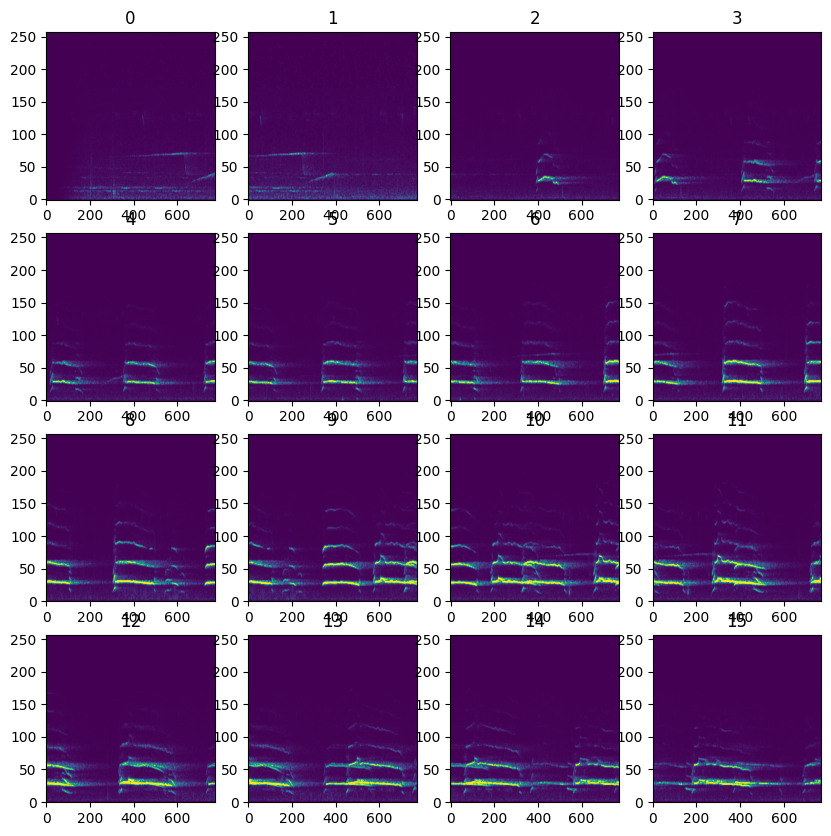

In [31]:
# Plot 16 spectrogram slice
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    # Get a window of the spectrogram
    sliceIndex = i
    spectrogramSlice = audioWindows[sliceIndex]
    ax[i // 4, i % 4].imshow(spectrogramSlice, aspect="auto", origin="lower")
    ax[i // 4, i % 4].set_title("{}".format(i))
plt.show()